<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [125]:
imsize = (224, 224)
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(imsize),
    transforms.ToTensor(),
])

def upload():
    print('Upload Content Image')
    file_dict = files.upload()
    content_path = io.BytesIO(file_dict[next(iter(file_dict))])
    
    print('\nUpload Style Image')
    file_dict = files.upload()
    style_path = io.BytesIO(file_dict[next(iter(file_dict))])
    return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving temple_content.jpeg to temple_content (4).jpeg

Upload Style Image


Saving starry_night_style.jpg to starry_night_style (6).jpg
Content Path: <_io.BytesIO object at 0x7f38bb70ca40>
Style Path: <_io.BytesIO object at 0x7f38bb70c830>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
#content_image = torch.transpose(content_image, 2, 3).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
    def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
    def __init__(self, requested=[]):
        super(VGGIntermediate, self).__init__()
        self.norm = Normalization().eval()
        self.intermediates = {}
        self.vgg = models.vgg16(pretrained=True).features.eval()
        for i, m in enumerate(self.vgg.children()):
            if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
                m.inplace = False          # the model has a hard time going backwards on the in place functions. 
                
            if i in requested:
                def curry(i):
                    def hook(module, input, output):
                        self.intermediates[i] = output
                    return hook
                m.register_forward_hook(curry(i))
                
    def forward(self, x):
        self.vgg(self.norm(x))
        return self.intermediates

In [128]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
vgg_int_names = np.arange(len(vgg_names))
vgg_name_dict = dict(zip(vgg_names, vgg_int_names))
# Choose the layers to use for style and content transfer

#Create the vgg network in eval mode
#with our forward method that returns the outputs of the intermediate layers we requested
requested_names = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv4_3", "conv5_1"]
requested = [vgg_name_dict[n] for n in requested_names]
vgg = VGGIntermediate(requested)

# Cache the outputs of the content and style layers for their respective images
vgg.vgg.cuda()
content_conv4_3 = vgg(content_image)[vgg_name_dict["conv4_3"]]
style_conv1_1 = vgg(style_image)[vgg_name_dict["conv1_1"]]
style_conv2_1 = vgg(style_image)[vgg_name_dict["conv2_1"]]
style_conv3_1 = vgg(style_image)[vgg_name_dict["conv3_1"]]
style_conv4_1 = vgg(style_image)[vgg_name_dict["conv4_1"]]
style_conv5_1 = vgg(style_image)[vgg_name_dict["conv5_1"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**
* Display the style tensor and content tensor transformed back to an image

**DONE:**


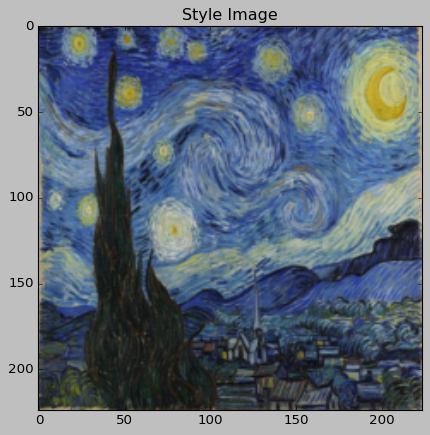

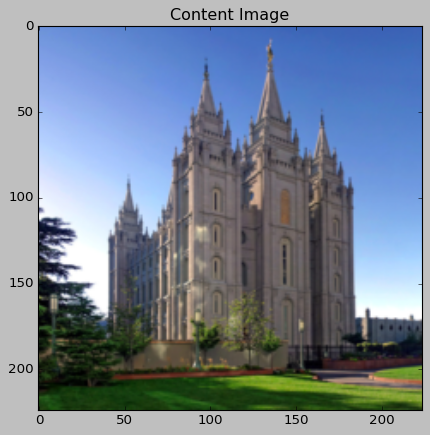

In [129]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        
plt.style.use("classic")
plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

___

### Part 3
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [0]:
def gram_matrix(input):
    """
    Calculates the gram matrix as given in equation (3) by Gatys
    
    Parameters:
        input ((1, c, h, width) tensor): a CNN intermediate representation
        
    Returns: (())
    """
    #Get sizes
    _, c, h, w = input.size()
    
    #Calculate F
    F = input.view(c, h*w)
    
    #Calculate G
    G = torch.mm(F, F.t())
    
    return G.div(c*h*w)
    
  
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        #Get sizes
        _, c, h, w = target.size()
        target = target.view(c, h*w)
        self.target = target.detach() #Detach so that we don't modify the Content image during backprop
    
    def forward(self, input):
        _, c, h, w = input.size()
        F2 = input.view(c, h*w)
        return F.mse_loss(F2, self.target)
    
    
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach() #Detach so that we don't modify the Style image during backprop
        
    def forward(self, input):
        G = gram_matrix(input)
        return F.mse_loss(G, self.target)

#Instantiate a content loss module for each content layer 
#with the content reference image outputs for that layer for comparison
cl_losses = {}
cl_losses["conv4_3"] = ContentLoss(content_conv4_3)

#Instantiate a sytle loss module for each style layer 
#with the style reference image outputs for that layer for comparison
sl_losses = {}
sl_losses["conv1_1"] = StyleLoss(style_conv1_1)
sl_losses["conv2_1"] = StyleLoss(style_conv2_1)
sl_losses["conv3_1"] = StyleLoss(style_conv3_1)
sl_losses["conv4_1"] = StyleLoss(style_conv4_1)
sl_losses["conv5_1"] = StyleLoss(style_conv5_1)

___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



In [150]:
# Start with a copy of the content image
x = content_image.clone()

#Run the optimizer on the images to change the image
#using the loss of the style and content layers
#to backpropagate errors
content_layers = ["conv4_3"]
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
optimizer = optim.Adam([x.requires_grad_()], lr=0.01)
alpha = 1000000
beta = 1

num_iters = 1000

w = 1/len(style_layers)
for i in range(num_iters):
    #Make sure outputs don't go out of range
    style_loss = 0
    content_loss = 0
    #zero the gradients
    optimizer.zero_grad()
    
    #Forward propagation
    for sl in style_layers:
        temp = vgg(x)[vgg_name_dict[sl]]
        style_loss += w*sl_losses[sl](temp)
        
        
    for cl in content_layers:
        temp2 = vgg(x)[vgg_name_dict[cl]]
        content_loss += cl_losses[cl](temp2)
        
        
    total_loss = alpha*style_loss + beta*content_loss
    
    #Calculate gradients
    total_loss.backward()
    
    #apply gradients
    optimizer.step()
    x.data.clamp_(0, 1)    
        
    if i % 50 == 0:
        print("Style Loss: {} Content Loss: {}".format(style_loss.item(), content_loss.item()))
        

Style Loss: 0.00669100834056735 Content Loss: 0.0
Style Loss: 0.00010970630683004856 Content Loss: 55.93755340576172
Style Loss: 6.255583139136434e-05 Content Loss: 50.061279296875
Style Loss: 4.73140535177663e-05 Content Loss: 47.267120361328125
Style Loss: 4.004975926363841e-05 Content Loss: 45.40968704223633
Style Loss: 3.5860481148120016e-05 Content Loss: 44.10872268676758
Style Loss: 3.258267679484561e-05 Content Loss: 42.97892379760742
Style Loss: 2.9549271857831627e-05 Content Loss: 42.0140495300293
Style Loss: 2.8818045393563807e-05 Content Loss: 41.235599517822266
Style Loss: 2.824258990585804e-05 Content Loss: 40.63419723510742
Style Loss: 2.7061905711889267e-05 Content Loss: 40.08226013183594
Style Loss: 2.571962795627769e-05 Content Loss: 39.63362121582031
Style Loss: 2.4826571461744606e-05 Content Loss: 39.2487678527832
Style Loss: 2.306042551936116e-05 Content Loss: 38.88224792480469
Style Loss: 2.410002525721211e-05 Content Loss: 38.594581604003906
Style Loss: 2.21877962

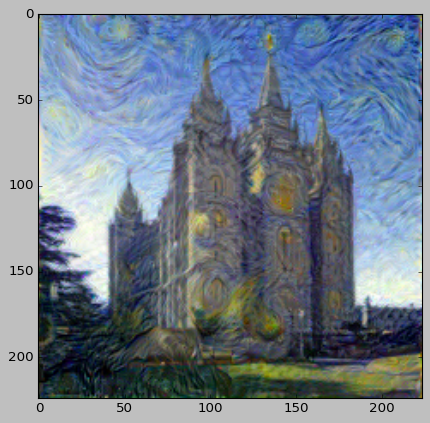

In [151]:
#Show the image
display(x)

### Part 5

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

(1) Content Loss

    Parameters:
        p: content image
        x: input image
        l: lth layer
        F: filter response to x (reshape the filters in the lth layer into a 2D matrix)
        P: filter response to p
        i,j indexing across rows and columns of F and P
        
    Explanation: The content loss in the lth layer is the sum of the squared errors between the content filter response and input filter response in the lth layer.
    
(3) Gram matrix

    Parameters:
        F: the filter response to an input (reshape the filters in the lth layer inot a 2D matrix)
        i, j indexing across rows and columns of F and P
        k indexing across row i of F and column j of F
        
    Explanation: This gives the ij entry of the Gram matrix as the inner product between the ith row and jth column of F. In practice, we calculate G = F.F^T
    
(4) Style loss in lth layer

    Parameters:
        G: the gram matrix of the input image
        A: the gram matrix of the style image
        l: lth layer
        Nl: the number of channels in the lth layer
        Ml: the number of parameters in a filter in the lth layer
        i,j: indexing across rows and columns of G and A
    
    Explanation: The style loss of the lth layer is the sum of the squared error between the Gram matrix of the input image and the Gram matrix of the style image. The result is normalized by 4Nl^2Ml^2
    
(5) Total style loss

    Parameters:
        a: the style image
        x: the input image
        l: indexing over layers
        L: the total number of layers
        El: the style loss of lth layer as caluculated in equation 4
        wl: a weight to use for El
        
    Explanation: The total style loss is the weighted sum of the the El's calculated for each layer l.
       